Number of rows: 1957
Number of columns: 35
Every row has the same number of elements.


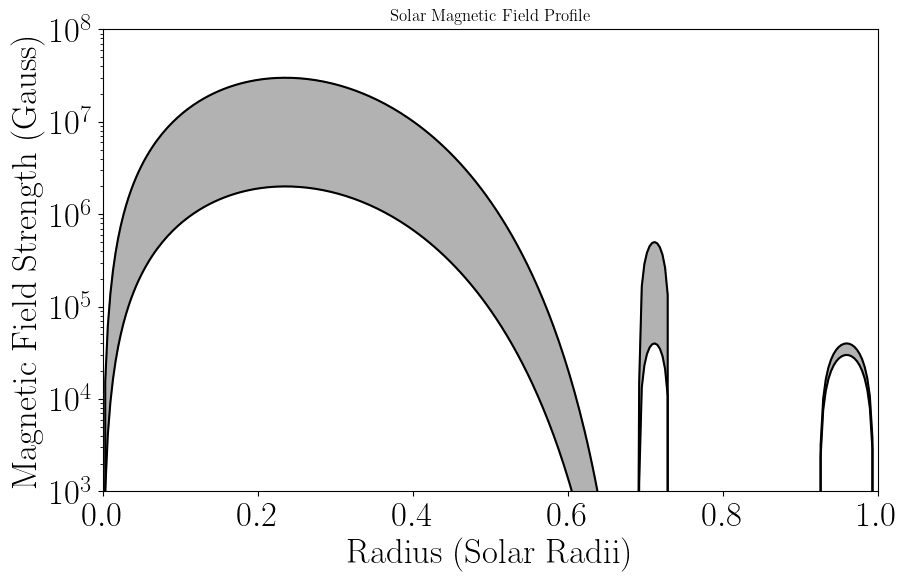

In [79]:
import requests
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import tplquad

def read_table_from_url(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            lines = response.text.split('\n')
            table_data = []
            for line in lines:
                # Skip comment lines starting with '#'
                if not line.startswith('#'):
                    # Split the line by whitespace and filter out empty elements
                    row = list(filter(None, line.strip().split()))
                    if row:
                        table_data.append(row)
            return table_data
        else:
            print("Failed to fetch data. Status code:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None
#change the address where to take the table
url_agss09 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09.dat"
url_gs98 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_gs98.dat"
url_agss09ph = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09ph.dat"
url_ags05 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_ags05.dat"
#change url here below
table_data = read_table_from_url(url_agss09)
#print("Properties of the solar model", table_data[1968:])
table_data = table_data[11:1968]
# Determine the number of rows and columns
num_rows = len(table_data)
num_columns = len(table_data[0]) if table_data else 0

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# Check if every row has the same number of elements
num_columns = len(table_data[0]) if table_data else 0
consistent = all(len(row) == num_columns for row in table_data)

if consistent:
    print("Every row has the same number of elements.")
else:
    print("Not every row has the same number of elements.")


# Convert table data to numpy arrays
table_data = np.array(table_data, dtype=float)

# Extract columns from the table data
mass_fraction = table_data[:, 0]
radius = table_data[:, 1]
temperature = table_data[:, 2]
density = table_data[:, 3]
pressure = table_data[:, 4]
luminosity_fraction = table_data[:, 5]

# Extract mass fractions of elements
element_mass_fractions = table_data[:, 6:]

# Interpolate each quantity as a function of radius
radius_interp_func = interp1d(radius, radius)
temperature_interp_func = interp1d(radius, temperature)
density_interp_func = interp1d(radius, density)
pressure_interp_func = interp1d(radius, pressure)
luminosity_interp_func = interp1d(radius, luminosity_fraction)

# Extract mass fractions of elements
element_mass_fractions = [table_data[:, i] for i in range(6, table_data.shape[1])]

# Interpolate mass fractions of elements as a function of radius
element_interp_funcs = []
for mass_fraction_array in element_mass_fractions:
    interp_func = interp1d(radius, mass_fraction_array, kind='linear')
    element_interp_funcs.append(interp_func)

atomic_numbers = [1, 2, 2, 6, 6, 7, 7, 8, 8, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
atomic_mass_numbers = [1, 4, 3, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 27, 28, 31, 32, 35, 40, 39, 40, 45, 48, 51, 52, 55, 56, 59, 59]

def kappa(radius):
    mu = 930 #MeV
    alpha= 1/137
    
    element_mass_fractions = [interp_func(radius) for interp_func in element_interp_funcs]
    ne = 0
    nbar = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
        nbar = nbar + (atomic_numbers[i]**2)*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    nbar = nbar * 0.561e+27 #in cm^-3
    res = np.sqrt(4*np.pi*alpha*(ne+nbar)/temperature_interp_func(radius))
    return res*9.43924e-9 #in keV

def omega_p(radius):
    mu = 930 #MeV
    alpha= 1/137
    me = 0.511 #MeV
    
    element_mass_fractions = [interp_func(radius) for interp_func in element_interp_funcs]
    ne = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    res = np.sqrt(4*np.pi*alpha*ne/me)
    return res*8.76376e-14 #in keV
##############################################################################################
######### MAGNETIC FIELD BELOW

def solar_magnetic_field(r, model):
    # Constants and parameters
    r0_conv = 0.96
    r0_rad = 0.712  # Solar radiative zone center (in units of solar radii)
    r0_tach = 0.712  # Tachocline and upper layers center (in units of solar radii)
    d_tach = 0.02  # Half-width of tachocline (in units of solar radii)
    d_upper = 0.035  # Half-width of upper layers (in units of solar radii)
    B_rad_min = 2.e6  # Minimum magnetic field intensity in radiative zone (in Gauss)
    B_rad_max = 3.e7  # Maximum magnetic field intensity in radiative zone (in Gauss)
    B_tach_min = 4.e4  # Minimum magnetic field intensity in tachocline (in Gauss)
    B_tach_max = 5.e5  # Maximum magnetic field intensity in tachocline (in Gauss)
    B_conv_max = 4.e4  # Maximum magnetic field intensity in upper layers (in Gauss)
    B_conv_min = 3.e4  # Minimum magnetic field intensity in upper layers (in Gauss)

    # Functions for radiative zone and tachocline
    def magnetic_field_radiative(r):
        lambda_val = 1 + 10 * r0_rad
        K_lambda = (1 + lambda_val) * (1 + 1 / lambda_val) ** lambda_val
        if model=='+':
            B_rad = B_rad_max * K_lambda * (r / r0_rad) ** 2 * (1 - (r / r0_rad) ** 2) ** lambda_val 
        else:
            B_rad = B_rad_min * K_lambda * (r / r0_rad) ** 2 * (1 - (r / r0_rad) ** 2) ** lambda_val
        return B_rad

    def magnetic_field_tachocline(r, r0, d, B_min, B_max):
        if model == '+':
            B_tach = B_max * (1 - ((r - r0) / d) ** 2)
        else:
            B_tach = B_min * (1 - ((r - r0) / d) ** 2)
        return B_tach

    # Determine the magnetic field based on the radius
    if r <= r0_rad - d_tach:
        B = magnetic_field_radiative(r)
    elif r0_tach - d_tach <= r <= r0_tach + d_tach:
        B = magnetic_field_tachocline(r, r0_tach, d_tach, B_tach_min, B_tach_max)
    elif r0_conv - d_upper < r <= r0_conv + d_upper:
        B = magnetic_field_tachocline(r, r0_conv, d_upper, B_conv_min, B_conv_max)
    else:
        B = 0  # Beyond the modeled region

    return B

# Generate radial values
r_values = np.linspace(0, 1, 300)

# Compute magnetic field for each radial value
B_values_up = [solar_magnetic_field(r,'+') for r in r_values]
# Compute magnetic field for each radial value
B_values_low = [solar_magnetic_field(r,'-') for r in r_values]

# Plot magnetic field as a function of radius
plt.figure(figsize=(10, 6))
plt.plot(r_values, B_values_low, color='black')
plt.plot(r_values, B_values_up, color='black')
# Fill between the curves
plt.fill_between(r_values, B_values_low, B_values_up, color='black', alpha=0.3) 


plt.title('Solar Magnetic Field Profile')
plt.xlabel('Radius (Solar Radii)')

# Customize the range of the plot
plt.xlim(0, 1)  # Custom x-axis limits
plt.ylim(1.e3, 1.e8)  # Custom y-axis limits

plt.ylabel('Magnetic Field Strength (Gauss)')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(False)
plt.show()

# Define constants
D_sun = 1.49e13  # Earth-Sun distance in cm

# Define the ALP production rate function. r in Rsun, omega_a and ma in keV, gag in GeV^-1, model=+,-
def Gamma_LP(r, omega_a, ma, gag, model):
    # Define your ALP production rate function here, for example:
    wp = omega_p(r) #keV, plasma frequency
    Tv = temperature_interp_func(r).item() * 8.617e-8 #keV
    fB = 1/(np.exp(omega_a/Tv)-1) #photon distribution
    Deltaag = (gag * solar_magnetic_field(r,model) / 2) * 1.95e-11 * 1.e-3#keV
    Gamma = 2.836e-4 * 1.e-3 #keV, absorption rate in the Sun approximated as constant
    if omega_a>max(ma,wp):
        return fB * (Gamma*Deltaag**2)/((wp-omega_a)**2 +(Gamma**2)/4) #keV
    else:
        return 0 

# Define the function dN_a_dt_dw_a. omega_a and ma in keV, gag in GeV^-1, model=+,-
def dNdtdw_LP(omega_a, ma, gag, model):
    g = 1  # Number of photon polarization states (1 for LP)
    # Define the integrand function
    def integrand(r, omega_a, ma):
        if omega_a**2 - omega_p(r)**2 > 0 and omega_a > ma:
            kg = np.sqrt(omega_a**2 - omega_p(r)**2)
        else:
            kg = 0
        return g * ((4 * np.pi)**2) * (r**2) * omega_a * kg * Gamma_LP(r, omega_a, ma, gag, model) / ((2 * np.pi)**3)
    # keV^3
    
    # Perform the integral
    r_min = table_data[:, 1].min()  
    r_max = table_data[:, 1].max()  
    result, _ = quad(integrand, r_min, r_max, args=(omega_a, ma))
    
    # Evaluate the flux
    return (1 / (4 * np.pi * D_sun**2)) * result * 6.666e73# in cm^-2 keV^-1 s^-1




# Define the ALP production rate function. r in Rsun, omega_a and ma in keV, gag in GeV^-1, model=+,-
def Gamma_TP(r, omega_a, ma, gag, model):
    # Define your ALP production rate function here, for example:
    wp = omega_p(r) #keV, plasma frequency
    Tv = temperature_interp_func(r).item() * 8.617e-8 #keV
    fB = 1/(np.exp(omega_a/Tv)-1) #photon distribution
    Deltaag = (gag * solar_magnetic_field(r,model) / 2) * 1.95e-11 * 1.e-3#keV
    Gamma = 2.836e-4 * 1.e-3 #keV, absorption rate in the Sun approximated as constant
    Deltap = (wp**2)/(2*omega_a) #keV
    Deltaa = (ma**2)/(2*omega_a) #keV
    if omega_a>max(ma,wp):
        return fB * (Gamma*Deltaag**2)/((Deltap-Deltaa)**2 +(Gamma**2)/4) #keV
    else:
        return 0 

# Define the function dN_a_dt_dw_a. omega_a and ma in keV, gag in GeV^-1, model=+,-
def dNdtdw_TP(omega_a, ma, gag, model):
    g = 2  # Number of photon polarization states (1 for LP)
    # Define the integrand function
    def integrand(r, omega_a, ma):
        if omega_a**2 - omega_p(r)**2 > 0 and omega_a > ma:
            kg = np.sqrt(omega_a**2 - omega_p(r)**2)
        else:
            kg = 0
        return g * ((4 * np.pi)**2) * (r**2) * omega_a * kg * Gamma_TP(r, omega_a, ma, gag, model) / ((2 * np.pi)**3)
    # keV^3
    
    # Perform the integral
    r_min = table_data[:, 1].min()  
    r_max = table_data[:, 1].max()  
    result, _ = quad(integrand, r_min, r_max, args=(omega_a, ma))
    
    # Evaluate the flux
    return (1 / (4 * np.pi * D_sun**2)) * result * 6.666e73# in cm^-2 keV^-1 s^-1

########################################################################################################
def dndEdt(r, omega, ma):
   
    #calculate the values to use 
    Tv = temperature_interp_func(r).item()
    Tv = Tv*0.862e-7
    kappav = kappa(r).item()
    omega_pv = omega_p(r).item()
    
    if omega<omega_pv or omega<ma:
        return 0
    
    k = np.sqrt((omega**2) - (omega_pv**2))
    p = np.sqrt((omega**2) - (ma*2))
    fomg = 1/(np.exp(omega/Tv)-1)
    
    P1 = ((k+p)**2 + kappav**2)*((k-p)**2 + kappav**2)/(4*p*k*(kappav**2))
    L1 = np.log(((k+p)**2 + kappav**2)/((k-p)**2 + kappav**2))
    P2 = ((k**2 - p**2)**2)/(4*p*k*(kappav**2))
    L2 = np.log(((k+p)**2)/((k-p)**2))

    res = k/(np.pi**2)
    res = res * omega*fomg*p/omega
    res = res * Tv*(kappav**2)/(32*np.pi)
    res = res * (P1*L1 - P2*L2 -1)
    return res * 4*np.pi*r**2 #keV^5


def dNdEdt(gag, omega, ma): 
    r_min = table_data[:, 1].min()  
    r_max = table_data[:, 1].max()    
    result, _ = quad(dndEdt, r_min, r_max, args=(omega, ma))
    result = result * (gag**2) * 6.68414*1.e+61 * 3.54e-28 #including 1/4pi d^2 if you uncomment. cm^-2
    return result #in keV^-1 s^-1 

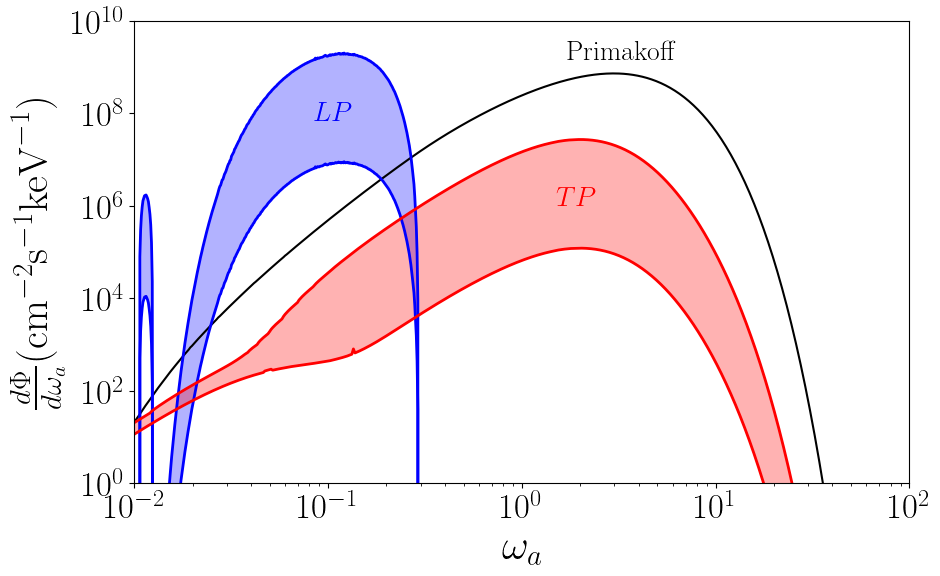

In [146]:


# Define the function dN_a_dt_dw_a. omega_a and ma in keV, gag in GeV^-1, model=+,-
def dNdtdw_LP_res(omega_a, ma, gag, model):
    def equation_to_solve(r):
        return omega_p(r) - omega_a

    if omega_a > omega_p(table_data[:, 1].min()) or omega_a < omega_p(table_data[:, 1].max()):
        rres = 0
    else:
        rres = root(equation_to_solve, 0.2).x[0] #resonance radius

    
    if rres < table_data[:, 1].min() or rres > table_data[:, 1].max():
        flx=0
    else:
        Tv = temperature_interp_func(rres).item() * 8.617e-8 #keV
        fB = 1/(np.exp(omega_a/Tv)-1) #photon distribution
        Deltaag = (gag * solar_magnetic_field(rres,model) / 2) * 1.95e-11 * 1.e-3#keV
        eps = 1.e-3
        der = eps/(omega_p(rres+eps)-omega_p(rres))
        if omega_a > ma:
            flx = (1 / (12 * np.pi * D_sun**2)) * (rres**2) * (omega_a**2) * np.abs(der) * fB * (2*Deltaag)**2
        else:
            flx = 0
    # keV^3 / cm^2      
    return flx * 6.666e73# in cm^-2 keV^-1 s^-1



# Customizing parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 30,   
    "xtick.labelsize": 25,  
    "ytick.labelsize": 25,  
    "legend.fontsize": 20,  
})

plt.figure(figsize=(10, 6))
gag = 1.e-11

# Define representative values of ma
ma = 0  #keV, You can customize these values

# Define omega_a range
omega_a = np.logspace(-2, 2, 500)  # Adjust the range as needed


# Compute axion flux
# flux1 =[dNdEdt(gag, oo, ma) for oo in omega_a] 

# Plot the axion flux
plt.plot(omega_a, flux1, color='black')


# Plot dNdtdw_LP for each ma value
omega_aLP = np.logspace(-2, 0, 500)
# LPup = [dNdtdw_LP_res(oo, ma, gag, '+') for oo in omega_aLP]
# LPdw = [dNdtdw_LP_res(oo, ma, gag, '-') for oo in omega_aLP]
# TPup = [dNdtdw_TP(oo, ma, gag, '+') for oo in omega_a]
# TPdw = [dNdtdw_TP(oo, ma, gag, '-') for oo in omega_a]
plt.plot(omega_aLP, LPup, linestyle='-', label=f'ma = {ma}', linewidth=2, color='blue')
plt.plot(omega_aLP, LPdw, linestyle='-', label=f'ma = {ma}', linewidth=2, color='blue')
# Fill between the curves
plt.fill_between(omega_aLP, LPdw, LPup, color='blue', alpha=0.3) 
plt.plot(omega_a, TPup, linestyle='-', label=f'ma = {ma}', linewidth=2, color='red')
plt.plot(omega_a, TPdw, linestyle='-', label=f'ma = {ma}', linewidth=2, color='red')
plt.fill_between(omega_a, TPdw, TPup, color='red', alpha=0.3) 

# Customize the range of the plot
plt.xlim(1.e-2, 50)  # Custom x-axis limits
plt.ylim(1.e0, 1.e10)  # Custom y-axis limits


# Add labels next to the lines
plt.text(0.085, 1.e8, r'$LP$', verticalalignment='center', fontsize=20, color='blue')
plt.text(1.5, 1.5e6, r'$TP$', verticalalignment='center', fontsize=20, color='red')
plt.text(1.7, 2.1e9, r'${\rm Primakoff}$', verticalalignment='center', fontsize=20, color='black')

# Customize the plot
plt.xlabel(r'$\omega_a$')
plt.ylabel(r'$\frac{d\Phi}{d\omega_a}({\rm cm}^{-2}{\rm s}^{-1}{\rm keV}^{-1})$')  # Assuming this is the ylabel format
plt.yscale('log')
plt.xscale('log')
plt.grid(False)

# Add more ticks
plt.xticks(np.logspace(-2, 2, 5))  # Adjust the number of ticks as needed
plt.yticks(np.logspace(0, 10, 6))  # Adjust the number of ticks as needed


# Save the plot as PDF
plt.savefig('dNdtdw_functions_plot.pdf', bbox_inches='tight')
plt.show()